# Analysis Template
WIP new analysis template. Only to be used with most recent version of kinetics package as of 11/21/23.

In [1]:
### PARAMETERS:
EGFP_SLOPE = 91900.03
EGFP_SLOPE_CONC_UNITS = 'nM' #RFU/nM


In [2]:
#enables autoreloding of modules
%load_ext autoreload
%autoreload 2

import os
from copy import deepcopy

import skimage
import math
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

from pathlib import Path 
from htbam_db_api.htbam_db_api import LocalHtbamDBAPI

#Import Kinetics Package for line fitting:
import kinetics

#Configuration settings for pandas and seaborn
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set(style='ticks', context='paper', font_scale=1.2, rc={"lines.linewidth": 1.2})

#enable inline plotting of matplotlib figures
%matplotlib inline

#set the figure format to SVG
%config InlineBackend.figure_format = 'svg'


/home/nfreitas/miniconda3/envs/htbam_analysis/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 0. Helper Functions

In [3]:
### Convert from DB to numpy arrays quickly:

def assay_data_to_array(db_obj, run_name):
    '''This function takes as input an HTBAM Database object.
    For each kinetics run, we have 
    It returns 3 numpy arrays:
    chamber_ids: an array of the chamber ids (in the format '1,1' ... '32,56')
        shape: (n_chambers,)
    luminance_data: an array of the luminance data for each chamber
        shape: (n_time_points, n_chambers, n_assays)
    conc_data: an array of the concentration data for each chamber.
        shape: (n_assays,)
    time_data: an array of the time data for each time point.
        shape: (n_time_points, n_assays)
    '''
    
    chamber_idxs = np.array(list(db_obj._json_dict['chamber_metadata'].keys()))
    luminance_data = None
    time_data = None
    conc_data = np.array([])

    #Each assay may have recorded a different # of time points.
    #First, we'll just check what the max # of time points is:
    max_time_points = 0
    for assay in db_obj._json_dict["runs"][run_name]['assays'].keys():
        current_assay_time_points = len(np.array(db_obj._json_dict["runs"][run_name]['assays'][assay]['time_s']))
        if current_assay_time_points > max_time_points:
            max_time_points = current_assay_time_points

    for assay in db_obj._json_dict["runs"][run_name]['assays'].keys():
        
        #to make things easier later, we'll be sorting the datapoints by time value.
        #Get time data:
        #collect from DB
        current_time_array = np.array(db_obj._json_dict["runs"][run_name]['assays'][assay]['time_s'])
        current_time_array = current_time_array.astype(float) #so we can pad with NaNs
        #pad the array with NaNs if there are fewer time points than the max
        current_time_array = np.pad(current_time_array, (0, max_time_points - len(current_time_array)), 'constant', constant_values=np.nan)
        #sort, and capture sorting idxs:
        sorting_idxs = np.argsort(current_time_array)
        current_time_array = current_time_array[sorting_idxs]
        current_time_array = np.expand_dims(current_time_array, axis=1)
        #add to our dataset
        if time_data is None:
            time_data = current_time_array
        else:
            time_data = np.concatenate([time_data, current_time_array], axis=1)

        #Get luminance data:
        current_luminance_array = None
        for chamber_idx in chamber_idxs:
            #collect from DB
            current_chamber_array = np.array(db_obj._json_dict["runs"][run_name]['assays'][assay]['chambers'][chamber_idx]['sum_chamber'])
            #set type to float:
            current_chamber_array = current_chamber_array.astype(float)
            #pad the array with NaNs if there are fewer time points than the max
            current_chamber_array = np.pad(current_chamber_array, (0, max_time_points - len(current_chamber_array)), 'constant', constant_values=np.nan)
            #sort by time:
            current_chamber_array = current_chamber_array[sorting_idxs]
            #add a dimension at the end:
            current_chamber_array = np.expand_dims(current_chamber_array, axis=1)

            if current_luminance_array is None:
                current_luminance_array = current_chamber_array
            else:
                current_luminance_array = np.concatenate([current_luminance_array, current_chamber_array], axis=1)
        #add a dimension at the end:
        current_luminance_array = np.expand_dims(current_luminance_array, axis=2)
        #add to our dataset
        if luminance_data is None:
            luminance_data = current_luminance_array
        else:
            luminance_data = np.concatenate([luminance_data, current_luminance_array], axis=2)
        
        #Get concentration data:
        #collect from DB
        current_conc = db_obj._json_dict["runs"][run_name]['assays'][assay]['conc']
        conc_data = np.append(conc_data, current_conc)

    #sort once more, by conc_data:
    sorting_idxs = np.argsort(conc_data)
    conc_data = conc_data[sorting_idxs]

    #sort luminance data by conc_data:
    luminance_data = luminance_data[:,:,sorting_idxs]
    
    return chamber_idxs, luminance_data, conc_data, time_data



In [4]:
### Plot a chip using a given variable, with subplots:

def plot_chip(plotting_var, chamber_names, graphing_function=None, title=None):
    ''' This function creates a Dash visualization of a chip, based on a certain Run (run_name)
        Inputs:
            plotting_var: a dictionary mapping chamber_id to the variable to be plotted for that chamber
            chamber_names: a dictionary mapping chamber_id to the name of the sample in the chamber (e.g. '1,1': ecADK_XYZ')
            graphing_function: a function that takes in a single chamber_id (e.g. '1,1') and matplotlib axis and returns the axis object after plotting.
            title: a string to be used as the title of the plot
        TODO: make all the variables stored in Dash properly...
    '''
    from dash import Dash, dcc, html, Input, Output, no_update
    import plotly.graph_objs as go
    import base64
    import tempfile

    # Make the image array
    #NB: eventually, store width/height in DB and reference!
    img_array = np.zeros([56,32])

    for chamber_id, value in plotting_var.items():
        x = int(chamber_id.split(',')[0])
        y = int(chamber_id.split(',')[1])
        img_array[y-1,x-1] = value 
    
    #generate title
    if title is None:
        title = ''
    
    #Create the figure
    layout = go.Layout()
    fig = go.Figure(layout=layout, data=go.Heatmap(z=img_array, colorscale='Viridis'))
    #center title in fig
    fig.update_layout(title=title,
                        title_x=0.5, 
                        yaxis=dict(scaleanchor="x", scaleratio=1, autorange='reversed'), 
                        xaxis=dict(scaleratio=1),
                        plot_bgcolor='rgba(0,0,0,0)',
                        width=600, height=600,
                        hovermode='x')
    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)

    #create dash app:
    app = Dash(__name__)
    app.layout = html.Div([
        dcc.Graph(id="graph", figure=fig, clear_on_unhover=True),
        dcc.Tooltip(id="graph-tooltip"),
    ])

    ### GRAPHING FUNCTION ON HOVER:
    if graphing_function is not None:
        @app.callback(
            Output("graph-tooltip", "show"),
            Output("graph-tooltip", "bbox"),
            Output("graph-tooltip", "children"),
            Input("graph", "hoverData"),
        )
        def display_hover(hoverData):
            if hoverData is None:
                return False, no_update, no_update
            # demo only shows the first point, but other points may also be available
            pt = hoverData["points"][0]
            chamber_id = str(pt['x']+1) + ',' + str(pt['y']+1)
            bbox = pt["bbox"]
            chamber_name = chamber_names[chamber_id]
            #get the data for the point:
            fig, ax = plt.subplots()
            ax = graphing_function(chamber_id, ax)
            #reduce whitespace on margins of graph:
            fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0, hspace=0)
            #save the figure as a temp file:
            tempfile_name = tempfile.NamedTemporaryFile().name+'.png'
            plt.savefig(tempfile_name)
            plt.close()
            # #read in temp file as base64 encoded string:
            with open(tempfile_name, "rb") as image_file:
                img_src = "data:image/png;base64," + str(base64.b64encode(image_file.read()).decode("utf-8"))
            children = [
                html.Div(children=[
                    #no space after header:
                    html.H3('{},{}:  {}'.format(pt['x'], pt['y'], chamber_name), style={"color": 'black', "fontFamily":"Arial", "textAlign": "center", "marginBottom": "0px"}),
                    #add the image with reduced whitespace:
                    html.Img(src=img_src, style={"width": "100%"}),
                ],
                style={'width': '400px', 'white-space': 'none'})
            ]

            return True, bbox, children

    app.run_server()

## 1. Connect DB Api

In [5]:
#from htbam_analysis.htbam_db_api import LocalHtbamDBAPI

root = '../local_test_data/'
db_conn = LocalHtbamDBAPI(standard_curve_data_path= root + 'd2_5_StandardSeries_Analysis.csv.bz2', standard_name="NADPH std curve", standard_type="NADPH", standard_units="uM",
                         kinetic_data_path= root+ 'd2_TitrationSeries_Analysis.csv.bz2', kinetic_name="ADP kinetics curve", kinetic_type="ADP", kinetic_units="uM")

### TODO: Still want the following data in the database:
# date (and time?) collected
# operator name
# Add additional descriptors
# substrate_name
# setup(?) and device_num
# width/height


#### Format of DB:
Useful? Or remove?
DB
- **chamber_metadata**
    - '1,1'
        - 'id'                  'organism_ADK'
        - 'radius_chamber'      35.0
        - 'x_center_chamber'    31.0
        - 'y_center_chamber'    43.0
        - 'xslice'              '(6758, 6805)'
        - 'yslice'              '(6704, 6804)'
    - ...
    - '32,56' ...
- **runs**
    - 'standard_0'
        - 'name'            'NAPDH_std_curve'
        - 'type'            'NAPDH'
        - 'conc_unit'       'uM'
        - 'assays':
            - 0:
                - 'conc'
                - 'time_s'
                - 'chambers'
                    - '1,1'
                    - ...
                    - '32,56' ...
            - ...
            - 6: ...
        - 'analyses':
            - 'linear_regression':
                - 'chambers':
                    - '1,1':
                        - slope:
                        - intercept:
                        - r_value:
                        - p_value: 
                        - std_err:
                    - ...
                    - '32,56'...


## 2. Standards

For each chamber, we've taken values at a set of concentrations. We need to perform a linear regression __for each chamber__ to relate the luminance of each chamber to its substrate concentration.

In our hierarchical data structure, we will store this linear regression as an analysis under the standard curve experiment. It is stored under:

```db_conn._json_dict['runs']['standard_0']['analyses']['linear_regression']```

And it stores the data:
```
{'chambers':  {'1,1': 
                     {'intercept': ...,
                      'p_value': ...,
                      'r2': ...,
                      'r_value': ...,
                      'slope': ...,
                      'std_err': ...,
                     }
               '1,2': {'intercept': ...}
              }
}
```


In [6]:
#Here, we collect our data into numpy arrays
chamber_idxs, luminance_data, conc_data, _ = assay_data_to_array(db_conn, 'standard_0')

#shape should be (time x wells x assays) or (1, 1792, 7) in the example data (not true???)
print('Luminance data shape:', luminance_data.shape)

#Perform linear regression for each chamber:
#and store immediately in 'database' object
if 'analyses' not in db_conn._json_dict['runs']['standard_0'].keys():
    db_conn._json_dict['runs']['standard_0']['analyses'] = {}

db_conn._json_dict['runs']['standard_0']['analyses']['linear_regression'] = {'chambers': {}} #initialize the dictionary
for i in range(len(chamber_idxs)):
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(conc_data, luminance_data[:,i])
    db_conn._json_dict['runs']['standard_0']['analyses']['linear_regression']['chambers'][chamber_idxs[i]] = {'slope': slope, 'intercept': intercept, 'r_value': r_value, 'r2':r_value**2, 'p_value': p_value, 'std_err': std_err}

Luminance data shape: (1, 1792, 7)


### Sanity check:
Now, let's sanity check by plotting. We can use the ```plot_chip()``` function to show a chip where each chamber is colored by variable (like luminance). We can also make subplots on hover.

In [7]:
#plotting variable: We'll plot by luminance. We need a dictionary mapping chamber id (e.g. '1,1') to the value to be plotted (e.g. slope)
slopes_to_plot = {chamber_idx: db_conn._json_dict['runs']['standard_0']['analyses']['linear_regression']['chambers'][chamber_idx]['slope'] for chamber_idx in chamber_idxs}

#chamber_names: We'll provide the name of the sample in each chamber as well, in the same way:
chamber_names_dict = {chamber_idx: subdict['id'] for chamber_idx, subdict in db_conn._json_dict['chamber_metadata'].items()}

#plotting function: We'll generate a subplot for each chamber, showing the raw data and the linear regression line.
# to do this, we make a function that takes in the chamber_id and the axis object, and returns the axis object after plotting. Do NOT plot.show() in this function.
def plot_chamber_slopes(chamber_id, ax):
    #parameters:
    run_name = 'standard_0'
    analysis_name = 'linear_regression'
    
    #convert from 'x,y' to integer index in the array:
    data_index = list(chamber_idxs).index(chamber_id)
    x_data = conc_data
    y_data = luminance_data[:,data_index]

    #get slope from the analysis:
    slope = np.array([db_conn._json_dict['runs'][run_name]['analyses'][analysis_name]['chambers'][chamber_idx]['slope'] for chamber_idx in chamber_idxs])
    intercept = np.array([db_conn._json_dict['runs'][run_name]['analyses'][analysis_name]['chambers'][chamber_idx]['intercept'] for chamber_idx in chamber_idxs])
    m = slope[data_index]
    b = intercept[data_index]
    #make a simple matplotlib plot
    ax.scatter(x_data, y_data)
    if not (np.isnan(m) or np.isnan(b)):
        #return False, no_update, no_update
        ax.plot(x_data, m*np.array(x_data) + b)
    return ax


### PLOT THE CHIP: now, we plot
plot_chip(slopes_to_plot, chamber_names_dict, graphing_function=plot_chamber_slopes, title='Standard Curve: Slope')



## 7. Fit initial rates from processed kinetic data

For this next part, we'll be generating the predicted product concentration for each well, for each time, and for each substrate concentration. That's a 3D array.

To do this, we divide our luminance value (in RFUs) by the slope of the chamber's standard curve (RFU/conc). Here, we ignore the standard curve intercept.

In [8]:
#Gather kinetics data into numpy arrays
chamber_idxs, luminance_data, conc_data, time_data = assay_data_to_array(db_conn, 'kinetics_0')
print('Luminance data shape:', luminance_data.shape) #(time x wells x assays)

Luminance data shape: (20, 1792, 11)


Each well contains time_series data. We have 32*56 wells (1792), and then N assays with different concentrations.
So we have a np array with dimensions (time x wells x assays)
For a standard, this will be (1, 1792, # concentrations)
For a kinetics run, this will be (~20, 1792, # concentrations)

In [9]:
slopes = np.array([db_conn._json_dict['runs']['standard_0']['analyses']['linear_regression']['chambers'][chamber_idx]['slope'] for chamber_idx in chamber_idxs])

#calculate product concentration by dividing every chamber intensity by the slope of the standard curve for that chamber
product_concentration = luminance_data / slopes[np.newaxis, :, np.newaxis]


In [10]:
#make numpy array of all button_quants with[ subtracted backgrounds:
button_quant_no_background = [] #we will soon turn this into a numpy array
for chamber_idx in chamber_idxs:
    next_button_quant = db_conn._json_dict['button_quant'][chamber_idx]['summed_button_BGsub_Button_Quant']
    button_quant_no_background.append(next_button_quant)
button_quant_no_background = np.array(button_quant_no_background)

# use eGFP standard curve to convert between button quant and eGFP concentration
enzyme_concentration = button_quant_no_background / EGFP_SLOPE    #in units of EGFP_SLOPE_CONC_UNITS
print('Enzyme concentration shape:', enzyme_concentration.shape)


Enzyme concentration shape: (1792,)


### Fit initial rates

/home/nfreitas/workspace/pinney/kinetic_analysis/kinetics/functions.py:52: RuntimeWarning:

invalid value encountered in scalar divide

/home/nfreitas/workspace/pinney/kinetic_analysis/kinetics/functions.py:57: RuntimeWarning:

invalid value encountered in scalar divide

/home/nfreitas/workspace/pinney/kinetic_analysis/kinetics/functions.py:58: RuntimeWarning:

invalid value encountered in scalar divide

/home/nfreitas/workspace/pinney/kinetic_analysis/kinetics/functions.py:89: RuntimeWarning:

invalid value encountered in scalar divide

/home/nfreitas/workspace/pinney/kinetic_analysis/kinetics/functions.py:92: RuntimeWarning:

invalid value encountered in scalar divide

/home/nfreitas/workspace/pinney/kinetic_analysis/kinetics/functions.py:93: RuntimeWarning:

invalid value encountered in scalar divide



 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to th

[2023-12-19 13:24:30,949] ERROR in app: Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/nfreitas/miniconda3/envs/htbam_analysis/lib/python3.10/site-packages/flask/app.py", line 1455, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/nfreitas/miniconda3/envs/htbam_analysis/lib/python3.10/site-packages/flask/app.py", line 869, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/nfreitas/miniconda3/envs/htbam_analysis/lib/python3.10/site-packages/flask/app.py", line 867, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/nfreitas/miniconda3/envs/htbam_analysis/lib/python3.10/site-packages/flask/app.py", line 852, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "/home/nfreitas/miniconda3/envs/htbam_analysis/lib/python3.10/site-packages/dash/dash.py", line 1310, in dispatch
    ctx.run(
  File "/home/nfreitas/miniconda3/envs/

 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to th

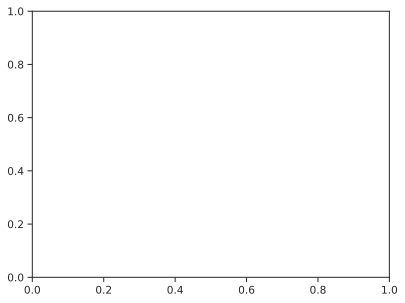

In [11]:
###TODO:
# 1) ~~I think addings nans kills the line fitting. Fix at some point. (in line fitting code, so we can keep nans?)~~
#    Fixed? Appears like it's working properly.
# 2) We're using the time values for the first chamber for all chambers. 
#    In practice, they're sometimes off by 1 second, which should not affect results much. Perhaps change in the future.
# 3) Kinetics fails without substrate_conc, even though it says it's optional. Also prints an ugly array which we should disable.

import kinetics

#make an array of initial slopes for each chamber: should be (#chambers , #concentrations) = (1792 x 11)
initial_slopes = None
initial_slopes_R2 = None
for i, chamber_idx in enumerate(chamber_idxs):

    #use the kinetics package to calculate the slopes for this chamber at each substrate concentration.
    current_chamber_slopes, current_chamber_R2 = kinetics.get_initial_slopes(time_data[:,0], product_concentration[:,i,:].T, substrate_concs=conc_data)

    #add a dimension at the end:
    current_chamber_slopes = np.expand_dims(current_chamber_slopes, axis=0)
    current_chamber_R2 = np.expand_dims(current_chamber_R2, axis=0)
    
    #add to our complete array:
    if initial_slopes is None:
        initial_slopes = current_chamber_slopes
        initial_slopes_R2 = current_chamber_R2
    else:
        initial_slopes = np.concatenate([initial_slopes, current_chamber_slopes], axis=0)
        initial_slopes_R2 = np.concatenate([initial_slopes_R2, current_chamber_R2], axis=0)

In [12]:
#Let's plot as before:
#plotting variable: We'll plot by luminance. We need a dictionary mapping chamber id (e.g. '1,1') to the value to be plotted (e.g. slope)
initial_rates_to_plot = {chamber_idxs[i]: np.nanmax(initial_slopes[i,:]) for i in range(len(chamber_idxs))}

#chamber_names: Same as before.

#plotting function: We'll generate a subplot for each chamber, showing the raw data and the linear regression line.
# to do this, we make a function that takes in the chamber_id and the axis object, and returns the axis object after plotting. Do NOT plot.show() in this function.
def plot_chamber_initial_rates(chamber_id, ax):
    #N.B. Every so often, slope and line colors don't match up. Not sure why.
    #parameters: what amount of total time to plot? First 20%?
    time_to_plot = 0.2
    
    #convert from 'x,y' to integer index in the array:
    data_index = list(chamber_idxs).index(chamber_id)

    x_data = time_data[:,0]
    y_data = product_concentration[:,data_index,:].T
    
    #plot only first X% of time:
    max_time = np.nanmax(x_data)
    time_to_plot = max_time*time_to_plot
    time_idxs_to_plot = x_data < time_to_plot
    x_data = x_data[time_idxs_to_plot]
    y_data = y_data[:, time_idxs_to_plot]
    
    #get slope from the analysis:
    current_chamber_slopes = initial_slopes[data_index,:]
    #calculate y-intercept by making sure it intersects first point:
    current_chamber_intercepts = y_data[:,0] - current_chamber_slopes*x_data[0] #note: not true y-intercept from linear regression
    
    for i in range(y_data.shape[0]): #over each concentration:
        ax.scatter(x_data, y_data[i,:])
        m = current_chamber_slopes[i]
        b = current_chamber_intercepts[i]
        if not (np.isnan(m) or np.isnan(b)):
            #return False, no_update, no_update
            ax.plot(x_data, m*np.array(x_data) + b)
    return ax


### PLOT THE CHIP: now, we plot
plot_chip(initial_rates_to_plot, chamber_names_dict, graphing_function=plot_chamber_initial_rates, title='Kinetics: Initial Rates (Max)')

/tmp/ipykernel_15824/663783430.py:3: RuntimeWarning:

All-NaN slice encountered



## 8. Filter initial rates

#### Filters:
We will filter by masking our product_concentration array with NaN values

In [13]:
### Filter threshholds ###

#standard curve r^2 threshhold:
r2_threshold = 0.98

#enzyme expression threshhold:
expression_threshhold = 1.5
expression_threshhold_units = 'nM'

#initial rate fit R^2 threshhold:
intitial_rate_R2_threshhold = 0.8

In [14]:
### Make filters ###

# STANDARD CURVE FILTER #
# overwrite all chambers (rows) with r^2 values below the threshold with NaNs:
filter_r2 = np.ones_like(initial_slopes)
r2_values = np.array([db_conn._json_dict['runs']['standard_0']['analyses']['linear_regression']['chambers'][chamber_idx]['r2'] for chamber_idx in chamber_idxs])
_count = 0
for i, chamber_idx in enumerate(chamber_idxs):
    if r2_values[i] < r2_threshold:
        _count +=1
        filter_r2[i, :] = np.nan
print('Pearson r^2 filter: {}/{} chambers pass'.format(len(chamber_idxs)-_count, len(chamber_idxs)))

# ENZYME EXPRESSION FILTER #
# overwrite all chambers (rows) with enzyme expression below the threshold with NaNs:
#Double check the expression units match the EGFP units:
assert expression_threshhold_units == EGFP_SLOPE_CONC_UNITS, 'Error, enzyme expression and EGFP standard curve units do not match!'
filter_enzyme_expression = np.ones_like(initial_slopes)
_count = 0
for i, chamber_idx in enumerate(chamber_idxs):
    if enzyme_concentration[i] < expression_threshhold:
        _count +=1
        filter_enzyme_expression[i,:] = np.nan
print('Enzyme expression filter: {}/{} chambers pass'.format(len(chamber_idxs)-_count, len(chamber_idxs)))

# INITIAL RATE FIT FILTER #
# overwrite just the assays per chamber (single values) with initial rate fit R^2 values below the threshold with NaNs:
filter_initial_rate_R2 = np.ones_like(initial_slopes)
_count = 0
for i, chamber_idx in enumerate(chamber_idxs):
    _chamber_count = 0
    for j in range(len(conc_data)):
        if initial_slopes_R2[i,j] < intitial_rate_R2_threshhold:
            _chamber_count +=1
            filter_initial_rate_R2[i,j] = np.nan
    if len(conc_data) - _chamber_count < 10:
        _count +=1
print('Initial Rate R^2 filter: {}/{} chambers pass with 10 or more slopes.'.format(len(chamber_idxs)-_count, len(chamber_idxs)))

# POSITIVE INITIAL SLOPE FILTER #
# overwrite just the assays per chamber (single values) with initial slopes below zero with NaNs:
filter_positive_initial_slope = np.ones_like(initial_slopes)
_count = 0
for i, chamber_idx in enumerate(chamber_idxs):
    _chamber_count = 0
    for j in range(len(conc_data)):
        if initial_slopes[i,j] < 0:
            _chamber_count +=1
            filter_positive_initial_slope[i,j] = np.nan
    if len(conc_data) - _chamber_count < 10:
        _count +=1
print('Positive Initial Slope filter: {}/{} chambers pass with 10 or more slopes.'.format(len(chamber_idxs)-_count, len(chamber_idxs)))


### manually flagged wells ###
#TODO: implement

### TODO: make visualization!


Pearson r^2 filter: 1792/1792 chambers pass
Enzyme expression filter: 1197/1792 chambers pass
Initial Rate R^2 filter: 1792/1792 chambers pass with 10 or more slopes.
Positive Initial Slope filter: 1544/1792 chambers pass with 10 or more slopes.


In [15]:
### Filter data ###
#apply filters:
filters = [filter_r2, filter_enzyme_expression, filter_initial_rate_R2, filter_positive_initial_slope]

filtered_initial_slopes = deepcopy(initial_slopes)
for filter in filters: filtered_initial_slopes *= filter

#then, filter our enzyme concentration:
enzyme_concentration_filtered = enzyme_concentration * filter_enzyme_expression[:,0]

In [16]:
# chamber_idxs, luminance_data, conc_data, time_data

#save filtered data to new analysis:
if 'analyses' not in db_conn._json_dict['runs']['kinetics_0'].keys():
    db_conn._json_dict['runs']['kinetics_0']['analyses'] = {}

#initialize the dictionary
db_conn._json_dict['runs']['kinetics_0']['analyses']['initial_slopes_filtered'] = {
        'filters': ['filter_r2', 'filter_enzyme_expression', 'filter_initial_rate_R2', 'filter_positive_initial_slope'],
        'filter_r2': r2_threshold,
        'filter_enzyme_expression': expression_threshhold,
        'filter_enzyme_expression_units': expression_threshhold_units,
        'filter_initial_rate_R2': intitial_rate_R2_threshhold,
        'filter_positive_initial_slope': True,
        'assays': {}} 

for i in range(len(conc_data)):
    db_conn._json_dict['runs']['kinetics_0']['analyses']['initial_slopes_filtered']['assays'][i] = {
        'substrate_conc': conc_data[i],
        'chambers': {}
    }
    for j, chamber_idx in enumerate(chamber_idxs):
        db_conn._json_dict['runs']['kinetics_0']['analyses']['initial_slopes_filtered']['assays'][i]['chambers'][chamber_idx] = {
            'slope': filtered_initial_slopes[j,i],
            'r2': initial_slopes_R2[j,i]
        }

In [17]:
###N.B.: May be some bug here, because some of the filtered-out chambers are still showing slopes.
# I think they should have all nans...?

#Let's plot as before:
#plotting variable: We'll plot by luminance. We need a dictionary mapping chamber id (e.g. '1,1') to the value to be plotted (e.g. slope)
filtered_initial_rates_to_plot = {chamber_idxs[i]: np.any(~np.isnan(filtered_initial_slopes[i,:])) for i in range(len(chamber_idxs))}

#chamber_names: Same as before.

#plotting function: We'll generate a subplot for each chamber, showing the raw data and the linear regression line.
# to do this, we make a function that takes in the chamber_id and the axis object, and returns the axis object after plotting. Do NOT plot.show() in this function.
def plot_chamber_filtered_initial_rates(chamber_id, ax):
    #N.B. Every so often, slope and line colors don't match up. Not sure why.
    #parameters: what amount of total time to plot? First 20%?
    time_to_plot = 0.2
    
    #convert from 'x,y' to integer index in the array:
    data_index = list(chamber_idxs).index(chamber_id)

    x_data = time_data[:,0]
    y_data = product_concentration[:,data_index,:].T
    
    #plot only first X% of time:
    max_time = np.nanmax(x_data)
    time_to_plot = max_time*time_to_plot
    time_idxs_to_plot = x_data < time_to_plot
    x_data = x_data[time_idxs_to_plot]
    y_data = y_data[:, time_idxs_to_plot]
    
    #get slope from the analysis:
    current_chamber_slopes = filtered_initial_slopes[data_index,:]
    #calculate y-intercept by making sure it intersects first point:
    current_chamber_intercepts = y_data[:,0] - current_chamber_slopes*x_data[0] #note: not true y-intercept from linear regression
    
    for i in range(y_data.shape[0]): #over each concentration:
        ax.scatter(x_data, y_data[i,:])
        m = current_chamber_slopes[i]
        b = current_chamber_intercepts[i]
        if not (np.isnan(m) or np.isnan(b)):
            #return False, no_update, no_update
            ax.plot(x_data, m*np.array(x_data) + b)
    return ax


### PLOT THE CHIP: now, we plot
plot_chip(filtered_initial_rates_to_plot, chamber_names_dict, graphing_function=plot_chamber_filtered_initial_rates, title='Kinetics: Filtered Initial Rates (Max)')
print('{}/1792 wells pass our filters.'.format( np.sum([x for x in filtered_initial_rates_to_plot.values()]) ) )

1177/1792 wells pass our filters.


## 9. Fit Michalis-Menten curves and visualize

**Important!** We must match our units for enzyme concentration with substrate concentration! 

In [18]:
substrate_conc_unit = db_conn._json_dict['runs']['kinetics_0']['conc_unit']
if  substrate_conc_unit != EGFP_SLOPE_CONC_UNITS: print('Substrate concentration units do not match EGFP standard curve units! \n{} != {}'.format(substrate_conc_unit, EGFP_SLOPE_CONC_UNITS))

unit_converstion = 0.001 #convert FROM eGFP units TO substrate units (in this case, nM to uM)
enzyme_concentration_converted_units = enzyme_concentration_filtered * unit_converstion

#Double check!
print('Conversion:')
print('{} {} = {} {}  ?'.format(enzyme_concentration[0], EGFP_SLOPE_CONC_UNITS, enzyme_concentration_converted_units[0], substrate_conc_unit))


Substrate concentration units do not match EGFP standard curve units! 
uM != nM
Conversion:
0.07712728711840464 nM = nan uM  ?


In [19]:
#Here, we calculate the Michaelis-Menten parameters for each chamber.

K_i_array = np.array([])
K_i_error_array = np.array([])

for i in range(len(chamber_idxs)):
    current_slopes = filtered_initial_slopes[i, :]

    if np.all(np.isnan(current_slopes)):
        print('Chamber {} has no slopes!'.format(chamber_idxs[i]))
        K_i_array = np.append(K_i_array, np.nan)
        K_i_error_array = np.append(K_i_error_array, np.nan)
        continue

    #get indices of non-nan values:
    non_nan_idxs = np.where(~np.isnan(current_slopes))[0]
    
    current_slopes = current_slopes[non_nan_idxs]
    current_concs = conc_data[non_nan_idxs]

    if len(current_slopes) < 3:
        print('Chamber {} has fewer than 3 slopes!'.format(chamber_idxs[i]))
        K_i_array = np.append(K_i_array, np.nan)
        K_i_error_array = np.append(K_i_error_array, np.nan)
        continue
    
    #kinetics.fit_and_plot_micheaelis_menten(current_slopes, current_slopes, current_concs, enzyme_concentration_converted_units[i], 'uM', 'MM for first chamber!')
    K_i, std_err = kinetics.fit_inhibition_constant(current_slopes, current_slopes, current_concs, enzyme_concentration_converted_units[i], 'uM', 'MM for first chamber!')
    K_i_array = np.append(K_i_array, K_i)
    K_i_error_array = np.append(K_i_error_array, std_err[0])


Chamber 1,1 has no slopes!
Chamber 1,2 has no slopes!
Chamber 1,3 has no slopes!
Chamber 1,6 has no slopes!
Chamber 1,8 has no slopes!
Chamber 1,13 has no slopes!
Chamber 1,14 has no slopes!
Chamber 1,18 has no slopes!
Chamber 1,21 has no slopes!
Chamber 1,22 has no slopes!
Chamber 1,25 has no slopes!
Chamber 1,26 has no slopes!
Chamber 1,29 has no slopes!
Chamber 1,30 has no slopes!
Chamber 1,32 has no slopes!
Chamber 1,34 has no slopes!
Chamber 1,36 has no slopes!
Chamber 1,39 has no slopes!
Chamber 1,40 has no slopes!
Chamber 1,45 has no slopes!
Chamber 1,46 has no slopes!
Chamber 1,48 has no slopes!
Chamber 1,56 has no slopes!
Chamber 2,1 has no slopes!
Chamber 2,5 has no slopes!
Chamber 2,8 has no slopes!
Chamber 2,13 has no slopes!
Chamber 2,14 has no slopes!
Chamber 2,18 has no slopes!
Chamber 2,22 has no slopes!
Chamber 2,26 has no slopes!
Chamber 2,33 has no slopes!
Chamber 2,35 has no slopes!
Chamber 2,37 has no slopes!
Chamber 2,40 has no slopes!
Chamber 2,41 has no slopes!


In [20]:
#Here, we calculate the Michaelis-Menten parameters for each chamber.

k_cat_array = np.array([])
k_cat_error_array = np.array([])
k_M_array = np.array([])
k_M_error_array = np.array([])

for i in range(len(chamber_idxs)):
    current_slopes = filtered_initial_slopes[i, :]

    if np.all(np.isnan(current_slopes)):
        print('Chamber {} has no slopes!'.format(chamber_idxs[i]))
        k_cat_array = np.append(k_cat_array, np.nan)
        k_cat_error_array = np.append(k_cat_error_array, np.nan)
        k_M_array = np.append(k_M_array, np.nan)
        k_M_error_array = np.append(k_M_error_array, np.nan)
        continue

    #get indices of non-nan values:
    non_nan_idxs = np.where(~np.isnan(current_slopes))[0]
    
    current_slopes = current_slopes[non_nan_idxs]
    current_concs = conc_data[non_nan_idxs]

    if len(current_slopes) < 3:
        print('Chamber {} has fewer than 3 slopes!'.format(chamber_idxs[i]))
        k_cat_array = np.append(k_cat_array, np.nan)
        k_cat_error_array = np.append(k_cat_error_array, np.nan)
        k_M_array = np.append(k_M_array, np.nan)
        k_M_error_array = np.append(k_M_error_array, np.nan)
        continue
    
    #kinetics.fit_and_plot_micheaelis_menten(current_slopes, current_slopes, current_concs, enzyme_concentration_converted_units[i], 'uM', 'MM for first chamber!')
    k_cat, k_M, std_err = kinetics.fit_michaelis_menten(current_slopes, current_slopes, current_concs, enzyme_concentration_converted_units[i], 'uM', 'MM for first chamber!')
    k_cat_array = np.append(k_cat_array, k_cat)
    k_cat_error_array = np.append(k_cat_error_array, std_err[0])
    k_M_array = np.append(k_M_array, k_M)
    k_M_error_array = np.append(k_M_error_array, std_err[1])

v_max_array = k_cat_array * enzyme_concentration_converted_units #in units of substrate_conc_unit
v_max_error_array = k_cat_error_array * enzyme_concentration_converted_units #in units of substrate_conc_unit

Chamber 1,1 has no slopes!
Chamber 1,2 has no slopes!
Chamber 1,3 has no slopes!
Chamber 1,6 has no slopes!
Chamber 1,8 has no slopes!
Chamber 1,13 has no slopes!
Chamber 1,14 has no slopes!
Chamber 1,18 has no slopes!
Chamber 1,21 has no slopes!
Chamber 1,22 has no slopes!
Chamber 1,25 has no slopes!
Chamber 1,26 has no slopes!
Chamber 1,29 has no slopes!
Chamber 1,30 has no slopes!
Chamber 1,32 has no slopes!
Chamber 1,34 has no slopes!
Chamber 1,36 has no slopes!
Chamber 1,39 has no slopes!
Chamber 1,40 has no slopes!
Chamber 1,45 has no slopes!
Chamber 1,46 has no slopes!
Chamber 1,48 has no slopes!
Chamber 1,56 has no slopes!
Chamber 2,1 has no slopes!
Chamber 2,5 has no slopes!
Chamber 2,8 has no slopes!
Chamber 2,13 has no slopes!
Chamber 2,14 has no slopes!
Chamber 2,18 has no slopes!
Chamber 2,22 has no slopes!
Chamber 2,26 has no slopes!
Chamber 2,33 has no slopes!
Chamber 2,35 has no slopes!
Chamber 2,37 has no slopes!
Chamber 2,40 has no slopes!
Chamber 2,41 has no slopes!


Now, we'll save the raw Michaelis Menten paremters to a new analysis in the DB

In [21]:
# chamber_idxs, luminance_data, conc_data, time_data

#save filtered data to new analysis:
if 'analyses' not in db_conn._json_dict['runs']['kinetics_0'].keys():
    db_conn._json_dict['runs']['kinetics_0']['analyses'] = {}

#initialize the dictionary
db_conn._json_dict['runs']['kinetics_0']['analyses']['michaelis_menten_raw'] = {
        'chambers': {}} 

for i, chamber_idx in enumerate(chamber_idxs):
    db_conn._json_dict['runs']['kinetics_0']['analyses']['michaelis_menten_raw']['chambers'][chamber_idx] = {
        'k_cat': k_cat_array[i],
        'k_cat_error': k_cat_error_array[i],
        'k_M': k_M_array[i],
        'k_M_error': k_M_error_array[i],
        'v_max': v_max_array[i],
        'v_max_error': v_max_error_array[i]
    }

Above, we've kept the Michaelis-Menten parameters grouped into their wells. Since we've run several replicates in different wells, we'll group them here by replicate, using the 'id' value:

In [22]:
#Get chamber ids from metadata:
chamber_name_to_idx = {}
for chamber_idx, subdict in db_conn._json_dict['chamber_metadata'].items():
    name = subdict['id']
    if name not in chamber_name_to_idx.keys():
        chamber_name_to_idx[name] = [chamber_idx]
    else:
        chamber_name_to_idx[name].append(chamber_idx)

#get average number of replicates:
n_replicates = np.mean([len(x) for x in chamber_name_to_idx.values()])
print('Average number of replicates per sample: {}'.format(np.round(n_replicates, 1)))

Average number of replicates per sample: 16.9


Here we gather and filter our MM-data. What z-score would we like to use to distinguish outliers?

In [23]:
z_score_threshhold_MM = 1.5
z_score_threshhold_expression = 1.5

In [24]:
#Get average k_cat, k_M, and v_max for each sample:
sample_names = np.array([])
sample_k_cat = np.array([])
sample_k_cat_error = np.array([])
sample_k_cat_replicates = []
sample_k_M = np.array([])           #in units of substrate_conc_unit
sample_k_M_error = np.array([])
sample_k_M_on_E = np.array([])           #in units of substrate_conc_unit
sample_k_M_on_E_error = np.array([])
sample_k_M_replicates = []
sample_v_max = np.array([])         #in units of substrate_conc_unit
sample_v_max_error = np.array([])
sample_v_max_replicates = []

#Get z-scores for each well (used to filter in the next step!)
k_cat_zscores = np.array([])
k_M_zscores = np.array([])
v_max_zscores = np.array([])
enzyme_concentration_zscores = np.array([])

#For each sample, 
for name, ids in chamber_name_to_idx.items():

    ### GATHER MM PARAMETERS OF REPLICATES FOR EACH SAMPLE: ###
    #get indices of idxs in chamber_idxs:
    idxs = [list(chamber_idxs).index(x) for x in ids]

    #get values for those indices:
    k_cat = k_cat_array[idxs]
    k_M = k_M_array[idxs]
    k_M_on_E = k_M_array[idxs]/enzyme_concentration_converted_units[idxs]
    v_max = v_max_array[idxs]
    #keep track of which wells we exclude later:
    k_cat_replicates = np.array(ids)
    k_M_replicates = np.array(ids)
    v_max_replicates = np.array(ids)

    #if any of these is all nans, just continue to avoid errors:
    if np.all(np.isnan(k_cat)) or np.all(np.isnan(k_M)) or np.all(np.isnan(v_max)):
        print('No values from sample {}, all pre-filtered.'.format(name))
        continue

    ### FILTER OUT OUTLIERS: ###
    #calculate z-score for each value:
    k_cat_zscore = (k_cat - np.nanmean(k_cat))/np.nanstd(k_cat)
    k_M_zscore = (k_M - np.nanmean(k_M))/np.nanstd(k_M)
    v_max_zscore = (v_max - np.nanmean(v_max))/np.nanstd(v_max)
    #also, get z-score of enzyme expression for each well:
    enzyme_concentration_zscore = (enzyme_concentration_converted_units[idxs] - np.nanmean(enzyme_concentration_converted_units[idxs]))/np.nanstd(enzyme_concentration_converted_units[idxs]) #in units of 'substrate_conc_unit' 

    #First, for enzyme expression outliers, set the value to NaN to be filtered in the final step:
    k_cat[np.abs(enzyme_concentration_zscore) > z_score_threshhold_expression] = np.nan
    k_M[np.abs(enzyme_concentration_zscore) > z_score_threshhold_expression] = np.nan
    k_M_on_E[np.abs(enzyme_concentration_zscore) > z_score_threshhold_expression] = np.nan
    v_max[np.abs(enzyme_concentration_zscore) > z_score_threshhold_expression] = np.nan

    #filter out values with z-score > threshhold:
    k_cat = k_cat[np.abs(k_cat_zscore) < z_score_threshhold_MM]
    k_M = k_M[np.abs(k_M_zscore) < z_score_threshhold_MM]
    k_M_on_E = k_M_on_E[np.abs(k_M_zscore) < z_score_threshhold_MM]
    v_max = v_max[np.abs(v_max_zscore) < z_score_threshhold_MM]
    #do the same for the replicates ids:
    k_cat_replicates = k_cat_replicates[np.abs(k_cat_zscore) < z_score_threshhold_MM]
    k_M_replicates = k_M_replicates[np.abs(k_M_zscore) < z_score_threshhold_MM]
    v_max_replicates = v_max_replicates[np.abs(v_max_zscore) < z_score_threshhold_MM]

    #remove nan values from all (nan values are due to both no experimental data, and z-score filtering)
    k_cat_replicates = k_cat_replicates[~np.isnan(k_cat)]
    k_M_replicates = k_M_replicates[~np.isnan(k_M)]
    v_max_replicates = v_max_replicates[~np.isnan(v_max)]
    k_cat = k_cat[~np.isnan(k_cat)]
    k_M = k_M[~np.isnan(k_M)]
    k_M_on_E = k_M_on_E[~np.isnan(k_M_on_E)]
    v_max = v_max[~np.isnan(v_max)]

    if len(k_cat) < 3:
        print('Not enough replicates for sample {}. Skipping.'.format(name))
        continue
    
    #get average values:
    sample_names = np.append(sample_names, name)
    sample_k_cat = np.append(sample_k_cat, np.mean(k_cat))
    sample_k_cat_error = np.append(sample_k_cat_error,np.std(k_cat))
    sample_k_M = np.append(sample_k_M, np.mean(k_M))
    sample_k_M_error = np.append(sample_k_M_error, np.std(k_M))
    sample_k_M_on_E = np.append(sample_k_M_on_E, np.mean(k_M_on_E))
    sample_k_M_on_E_error = np.append(sample_k_M_on_E_error, np.std(k_M_on_E))
    sample_v_max = np.append(sample_v_max, np.mean(v_max))
    sample_v_max_error = np.append(sample_v_max_error, np.std(v_max))
    #keep track of replicates:
    sample_k_cat_replicates.append(k_cat_replicates)
    sample_k_M_replicates.append(k_M_replicates)
    sample_v_max_replicates.append(v_max_replicates)



No values from sample M_caps_ADK, all pre-filtered.
No values from sample P_syri_ADK, all pre-filtered.
No values from sample P_chlo_ADK, all pre-filtered.


No values from sample B_lich_ADK, all pre-filtered.
No values from sample P_furi_ADK, all pre-filtered.
No values from sample T_mela_ADK, all pre-filtered.
No values from sample C_parv_ADK, all pre-filtered.
No values from sample A_salm_ADK, all pre-filtered.
No values from sample L_chol_ADK, all pre-filtered.
No values from sample M_burt_ADK, all pre-filtered.
No values from sample M_myco_ADK, all pre-filtered.
No values from sample C_trac_ADK, all pre-filtered.
No values from sample S_cell_ADK, all pre-filtered.
No values from sample T_gamm_ADK, all pre-filtered.
No values from sample A_deha_ADK, all pre-filtered.
No values from sample S_hali_ADK, all pre-filtered.
No values from sample L_inte_ADK, all pre-filtered.
No values from sample T_afri_ADK, all pre-filtered.
No values from sample T_mari_ADK, all pre-filtered.
No values from sample H_mode_ADK, all pre-filtered.
No values from sample A_caul_ADK, all pre-filtered.
No values from sample E_tasm_ADK, all pre-filtered.
Not enough r

/tmp/ipykernel_15824/2717692256.py:45: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_15824/2717692256.py:45: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_15824/2717692256.py:46: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_15824/2717692256.py:46: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_15824/2717692256.py:47: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_15824/2717692256.py:47: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_15824/2717692256.py:49: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_15824/2717692256.py:49: RuntimeWarning:

invalid value encountered in divide



Now, we add this to the database:

In [25]:
#save filtered data to new analysis:
if 'analyses' not in db_conn._json_dict['runs']['kinetics_0'].keys():
    db_conn._json_dict['runs']['kinetics_0']['analyses'] = {}

#initialize the dictionary
db_conn._json_dict['runs']['kinetics_0']['analyses']['michaelis_menten_filtered'] = {
        'samples': {}} 

for i, sample_name in enumerate(sample_names):
    db_conn._json_dict['runs']['kinetics_0']['analyses']['michaelis_menten_filtered']['samples'][sample_name] = {
        'k_cat': sample_k_cat[i],
        'k_cat_error': sample_k_cat_error[i],
        'k_cat_replicates': sample_k_cat_replicates[i],
        'k_M': sample_k_M[i],
        'k_M_error': sample_k_M_error[i],
        'k_M/E': sample_k_M_on_E[i],
        'k_M/E_error': sample_k_M_on_E_error[i],
        'k_M_replicates': sample_k_M_replicates[i],
        'v_max': sample_v_max[i],
        'v_max_error': sample_v_max_error[i],
        'v_max_replicates': sample_v_max_replicates[i]
    }

In [31]:
#visualize:
#plotting variable: We'll plot by K_M. We need a dictionary mapping chamber id (e.g. '1,1') to the value to be plotted
#first, fill it with NaNs as a placeholder:
k_M_to_plot = {chamber_idx: np.nan for chamber_idx in chamber_idxs}
V_max_to_plot = {chamber_idx: np.nan for chamber_idx in chamber_idxs}
#then, fill in the values we have:
for i in range(len(sample_names)):
    for chamber_idx in chamber_name_to_idx[sample_names[i]]:
        k_M_to_plot[chamber_idx] = sample_k_M[i]
for i in range(len(sample_names)):
    for chamber_idx in chamber_name_to_idx[sample_names[i]]:
        V_max_to_plot[chamber_idx] = sample_v_max[i]

#plotting function: We'll generate an MM subplot for each chamber.
def plot_chamber_MM(chamber_id, ax):
    def mm_model(x, v_max, Km):
        # Michaelis-Menten equation to model enzyme kinetics.
        # 'x': substrate concentration, 'v_max': maximum reaction rate, 'Km': Michaelis constant.
        return v_max * x / (x + Km)
    
    #find the name of the chamber:
    chamber_name = chamber_names_dict[chamber_id]
    #first, find all chambers with this name:
    #if there's no data, just skip!
    if chamber_name not in db_conn._json_dict['runs']['kinetics_0']['analyses']['michaelis_menten_filtered']['samples']:
        return ax
    chamber_id_list = db_conn._json_dict['runs']['kinetics_0']['analyses']['michaelis_menten_filtered']['samples'][chamber_name]['k_M_replicates']

    #convert to array indices:
    chamber_id_list = [list(chamber_idxs).index(x) for x in chamber_id_list]

    #get the initial rates for each chamber:
    initial_slopes = filtered_initial_slopes[chamber_id_list,:]
    #divide by enzyme concentration:
    initial_slopes_on_E = initial_slopes / enzyme_concentration_converted_units[chamber_id_list, np.newaxis]
    #get average
    initial_slopes_on_E_avg = np.nanmean(initial_slopes_on_E, axis=0)
    #get error bars
    initial_slopes_on_E_std = np.nanstd(initial_slopes_on_E, axis=0)

    #get the substrate concentrations that match with each initial rate:
    substrate_concs = conc_data

    x_data = substrate_concs
    y_data = initial_slopes_on_E_avg

    data_index = list(chamber_idxs).index(chamber_id)
    current_chamber_slopes = filtered_initial_slopes[data_index,:]
    current_chamber_slopes_on_E = current_chamber_slopes / enzyme_concentration_converted_units[data_index]
    
    #make x,y labels:
    ax.set_xlabel('[S] ({})'.format(substrate_conc_unit))
    ax.set_ylabel('KM/[E]')

    #plot with error bars:
    ax.errorbar(x_data, y_data, yerr=initial_slopes_on_E_std, fmt='o', label="all replicates")

    #plot the fit:
    #get the Ki and v_0 from the database:
    KM = k_M_to_plot[chamber_id]
    V_max = V_max_to_plot[chamber_id]
    
    #get enzyme concentration:
    enzyme_conc = np.nanmean(enzyme_concentration_converted_units[chamber_id_list])

    #plot dotted line
    ax.plot(x_data, mm_model(x_data, V_max, KM)/enzyme_conc, '--', linewidth=2,  label="MM fit")

    #plot over everything else:
    ax.scatter(x_data, current_chamber_slopes_on_E, marker='o', color='red', s=50, zorder=10,  label="current chamber")

    ax.legend()
    
    return ax

#chamber_names: We'll provide the name of the sample in each chamber as well, in the same way:
chamber_names_dict = {chamber_idx: subdict['id'] for chamber_idx, subdict in db_conn._json_dict['chamber_metadata'].items()}

### PLOT THE CHIP: now, we plot
plot_chip(k_M_to_plot, chamber_names_dict, graphing_function=plot_chamber_MM, title='Filtered K_M')

/tmp/ipykernel_15824/2953188459.py:37: RuntimeWarning:

Mean of empty slice

/home/nfreitas/miniconda3/envs/htbam_analysis/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning:

Degrees of freedom <= 0 for slice.



In [27]:
#Idea: Once we have initial fit for KM, have a view that flags each well by substrate "coverage":
#that is, whether our experiment had 1/10th and 10x substrate concentration than Vmax
# In the future, add a way to include more metadata like optimal growth temperature and full organism name

## 10.a. Export to CSV in format people like

In [29]:
#Summary CSV, showing data for each SAMPLE:
output_csv_name = 'kinetics_summary'

import csv
with open(output_csv_name+'_short.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    #write header:
    writer.writerow(['id', 
                     'substrate_name', 
                     'assay_type', 
                     'replicates', 
                     'kcat_mean_filtered', 
                     'kcat_stdev_filtered', 
                     'Km_mean_filtered', 
                     'Km_stdev_filtered', 
                     'enzyme', 
                     'vmax_mean_filtered', 
                     'vmax_stdev_filtered'])
    #write data:
    for i, sample_name in enumerate(sample_names):
        #get the chamber indices for this sample:
        chamber_indices = np.where(np.isin(chamber_idxs, chamber_name_to_idx[sample_name]))[0]
        #get average enzyme conc:
        enzyme_conc = np.nanmean(enzyme_concentration_converted_units[chamber_indices])
        row = [sample_name,
               sample_name,
               db_conn._json_dict['runs']['kinetics_0']['type'], 
               len(sample_k_cat_replicates[i]), 
               sample_k_cat[i], 
               sample_k_cat_error[i], 
               sample_k_M[i], 
               sample_k_M_error[i], 
               enzyme_conc,
               sample_v_max[i], 
               sample_v_max_error[i]]
        writer.writerow(row)

In [30]:
#Full CSV, showing data for each CHAMBER:
output_csv_name = 'kinetics'

import csv
with open(output_csv_name+'.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    #write header:
    writer.writerow(['id', 
                     'x,y',
                     'substrate_name', 
                     'assay_type', 
                     'replicates', 
                     'kcat', 
                     'kcat_mean_filtered', 
                     'kcat_stdev_filtered', 
                     'Km', 
                     'Km_mean_filtered', 
                     'Km_stdev_filtered', 
                     'enzyme',
                     'vmax', 
                     'vmax_mean_filtered', 
                     'vmax_stdev_filtered'])
    #write data for each chamber:
    for i, chamber_idx in enumerate(chamber_idxs):
        sample_name = chamber_names_dict[chamber_idx]
        #get index in sample_names:
        if sample_name in sample_names:
            sample_idx = list(sample_names).index(sample_name)
            row = [chamber_names_dict[chamber_idx], #id
                    chamber_idx, #x,y
                    sample_name, #substrate_name
                    db_conn._json_dict['runs']['kinetics_0']['type'], #assay_type
                    len(sample_k_cat_replicates[sample_idx]), #replicates
                    db_conn._json_dict['runs']['kinetics_0']['analyses']['michaelis_menten_raw']['chambers'][chamber_idx]['k_cat'], #kcat
                    sample_k_cat[sample_idx], #kcat_mean_filtered
                    sample_k_cat_error[sample_idx], #kcat_stdev_filtered
                    db_conn._json_dict['runs']['kinetics_0']['analyses']['michaelis_menten_raw']['chambers'][chamber_idx]['k_M'], #Km
                    sample_k_M[sample_idx], #Km_mean_filtered
                    sample_k_M_error[sample_idx], #Km_stdev_filtered
                    enzyme_concentration_converted_units[i], #enzyme
                    db_conn._json_dict['runs']['kinetics_0']['analyses']['michaelis_menten_raw']['chambers'][chamber_idx]['v_max'], #vmax
                    sample_v_max[sample_idx], #vmax_mean_filtered
                    sample_v_max_error[sample_idx]] #vmax_stdev_filtered
        else:
            row = [chamber_names_dict[chamber_idx], #id
                    chamber_idx, #x,y
                    sample_name, #substrate_name
                    db_conn._json_dict['runs']['kinetics_0']['type'], #assay_type
                    'NaN', #replicates
                    db_conn._json_dict['runs']['kinetics_0']['analyses']['michaelis_menten_raw']['chambers'][chamber_idx]['k_cat'], #kcat
                    'NaN', #kcat_mean_filtered
                    'NaN', #kcat_stdev_filtered
                    db_conn._json_dict['runs']['kinetics_0']['analyses']['michaelis_menten_raw']['chambers'][chamber_idx]['k_M'], #Km
                    'NaN', #Km_mean_filtered
                    'NaN', #Km_stdev_filtered
                    enzyme_concentration_converted_units[i], #enzyme
                    db_conn._json_dict['runs']['kinetics_0']['analyses']['michaelis_menten_raw']['chambers'][chamber_idx]['v_max'], #vmax
                    'NaN', #vmax_mean_filtered
                    'NaN' #vmax_stdev_filtered
            ]
        
        writer.writerow(row)